In [12]:
import os
import pandas as pd
import numpy as np
import anndata
import time
import json
import matplotlib.pyplot as plt
import requests

In [13]:
version = '20230830'
download_base = '/orangedata/ExternalData/Allen-WMB'

use_local_cache = False
manifest_path = 'releases/%s/manifest.json' % version

if not use_local_cache :
    url = 'https://allen-brain-cell-atlas.s3-us-west-2.amazonaws.com/' + manifest_path
    manifest = json.loads(requests.get(url).text)
else :
    file = os.path.join(download_base,manifest_path)
    with open(file,'rb') as f:
        manifest = json.load(f)
    
metadata = manifest['file_listing']['MERFISH-C57BL6J-638850']['metadata']

view_directory = os.path.join( download_base, 
                               manifest['directory_listing']['MERFISH-C57BL6J-638850']['directories']['metadata']['relative_path'], 
                              'views')
cache_views = False
if cache_views :
    os.makedirs( view_directory, exist_ok=True )

ConnectionError: HTTPSConnectionPool(host='allen-brain-cell-atlas.s3-us-west-2.amazonaws.com', port=443): Max retries exceeded with url: /releases/20230830/manifest.json (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x7f037d64f6a0>: Failed to resolve 'allen-brain-cell-atlas.s3-us-west-2.amazonaws.com' ([Errno -2] Name or service not known)"))

In [ ]:
rpath = metadata['cell_metadata']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath)
# Check if file exists, override rpath if not
if not os.path.exists(file):
    rpath = 'metadata/MERFISH-C57BL6J-638850/20230630/cell_metadata.csv'
    file = os.path.join(download_base, rpath)

cell = pd.read_csv(file, dtype={"cell_label":str})
cell.set_index('cell_label',inplace=True)

In [ ]:
def print_column_info(df) :
    
    for c in df.columns :
        grouped = df[[c]].groupby(c).count()
        members = ''
        if len(grouped) < 30 :
            members = str(list(grouped.index))
        print("Number of unique %s = %d %s" % (c,len(grouped),members))

In [ ]:
taxonomy_metadata = manifest['file_listing']['WMB-taxonomy']['metadata']

rpath = '/orangedata/ExternalData/Allen-WMB/metadata/WMB-taxonomy/20230630/views/cluster_to_cluster_annotation_membership_pivoted.csv'
file = os.path.join(download_base, rpath)

cluster_details = pd.read_csv(file,keep_default_na=False)
cluster_details.set_index('cluster_alias', inplace=True)

In [ ]:
rpath = '/orangedata/ExternalData/Allen-WMB/metadata/WMB-taxonomy/20230630/views/cluster_to_cluster_annotation_membership_color.csv'
file = os.path.join(download_base, rpath)

cluster_colors = pd.read_csv(file)
cluster_colors.set_index('cluster_alias', inplace=True)

In [ ]:
cell_extended = cell.join(cluster_details,on='cluster_alias')
cell_extended = cell_extended.join(cluster_colors,on='cluster_alias')

if cache_views :
    file = os.path.join( view_directory, 'cell_metadata_with_cluster_annotation.csv')
    cell_extended.to_csv( file )

In [ ]:
file = '/orangedata/ExternalData/Allen-WMB/metadata/MERFISH-C57BL6J-638850/20230630/gene.csv'

gene = pd.read_csv(file)
gene.set_index('gene_identifier',inplace=True)
#print("Number of genes = ", len(gene))
gene.head(5)

expression_matrices = manifest['file_listing']['MERFISH-C57BL6J-638850']['expression_matrices']
#expression_matrices['C57BL6J-638850']

In [ ]:
def plot_section( xx, yy, cc=None, val=None, fig_width = 8, fig_height = 8, cmap=None ) :
    fig, ax = plt.subplots()
    fig.set_size_inches(fig_width, fig_height)
    if cmap is not None :
        plt.scatter(xx,yy,s=0.5,c=val,marker='.',cmap=cmap)
    elif cc is not None :
        plt.scatter(xx,yy,s=0.5,color=cc,marker='.')
    ax.set_ylim(11,0)
    ax.set_xlim(0,11)
    ax.axis('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    
    return fig, ax

Section = C57BL6J-638850.36

In [ ]:
selected_section = 'C57BL6J-638850.36'

In [ ]:
#Section = C57BL6J-638850.38

pred = (cell_extended['brain_section_label'] == selected_section)
section = cell_extended[pred]
#print("Number of cells in section:",len(section))

#cluster_colors

cell_extended.head()
section = cell_extended[cell_extended['brain_section_label'] == selected_section] #30 classes

Mapping own colors onto allen brain

In [ ]:
# #Legacy code

# final_color_array_division = np.loadtxt("/home/timothy/allen/other_hierarchies/objective_function/division/transformed_colors_division.txt")
# # Get unique class colors in section[division_color]
# unique_division_colors = section['division_color'].unique()

# # Convert RGB colors to hex
# hex_colors_division = ['#' + ''.join([format(int(c), '02x') for c in color]) for color in final_color_array_division]

# # Create a dictionary mapping unique division colors to hex colors
# color_mapping_division = dict(zip(unique_division_colors, hex_colors_division))

# # Replace colors in section[division_color] with hex colors
# new_section = section.copy()
# new_section['division_color'] = new_section['division_color'].replace(color_mapping_division)

In [ ]:
def update_section_colors(color_path, hierarchy, brain_section):
    """
    Updates the colors in a given section based on the specified hierarchy.

    Args:
    color_path (str): File path to the color data.
    Hierarchy type (e.g., 'class', 'cluster', 'division', etc.).
    brain_section (pd.DataFrame): DataFrame containing the brain section data.

    Returns:
    pd.DataFrame: A new brain section DataFrame with updated colors.
    """

    try:
        final_color_array = np.loadtxt(color_path)
    except Exception as e:
        print(f"Failed to load color data from {color_path}: {e}")
        return


    # Make a copy of the brain_section DataFrame
    new_brain_section = brain_section.copy()

    # Load color array from the file
    final_color_array = np.loadtxt(color_path)

    # Get unique colors in specified hierarchy
    unique_hierarchy_colors = new_brain_section[f'{hierarchy}_color'].unique()

    # Convert RGB colors to hex
    hex_colors = ['#' + ''.join([format(int(c), '02x') for c in color]) for color in final_color_array]

    # Create dictionary mapping unique hierarchy colors to hex colors
    color_mapping = dict(zip(unique_hierarchy_colors, hex_colors))

    # Replace colors in the brain section with hex colors
    new_brain_section[f'{hierarchy}_color'] = new_brain_section[f'{hierarchy}_color'].replace(color_mapping)

    return new_brain_section


In [ ]:
division_colors = "/home/timothy/allen/division_transform_test/round2colors_rgb.txt"
hierarchy = 'division'

In [ ]:
new_section = update_section_colors(color_path = division_colors, hierarchy = hierarchy, brain_section = section)

new_section
#new_section = update_section_colors(color_path='/home/timothy/allen/linear_transformations/class_shiftscale_rotations_results/lab_scaled_final_rgb_255_singlerotation000.txt', hierarchy='class', brain_section=new_section)

NameError: name 'section' is not defined

In [ ]:
def plot_section_class(section_df=new_section, title="Class Colors", save_path=None, fig_width=8, fig_height=8, cmap=None):
    """
    Plots a scatter plot based on the section DataFrame with 'class' as the hierarchy.
    Optionally saves the plot if a save path is provided.

    Args:
    section_df (pd.DataFrame, optional): DataFrame containing the section data. Defaults to an empty DataFrame.
    title (str, optional): Title of the plot. Defaults to "Class Colors".
    save_path (str, optional): File path to save the plot. If None, the plot is not saved. Defaults to None.
    fig_width (int, optional): Width of the figure. Defaults to 8.
    fig_height (int, optional): Height of the figure. Defaults to 8.
    cmap (str, optional): Colormap used for plotting. Defaults to None.
    """

    fig, ax = plt.subplots()
    fig.set_size_inches(fig_width, fig_height)

    if section_df.empty:
        print("Warning: DataFrame is empty. No plot will be generated.")
        return

    # Extract data
    xx = section_df['x']
    yy = section_df['y']
    cc = section_df['class_color']  # Adjusted for class hierarchy

    # Random permutation of the indices
    indices = np.random.permutation(len(xx))

    # Scatter plot
    if cmap is not None:
        sc = ax.scatter(xx[indices], yy[indices], s=0.5, c=cc[indices], marker='.', cmap=cmap, alpha=1)
    else:
        sc = ax.scatter(xx[indices], yy[indices], s=0.5, color=cc[indices], marker='.', alpha=1)

    ax.set_ylim(11, 0)
    ax.set_xlim(0, 11)
    ax.axis('equal')
    ax.set_xticks([])
    ax.set_yticks([])

    # Add legend
    if cmap is None:
        unique_colors = np.unique(cc)
        legend_elements = []
        for color in unique_colors:
            class_rows = section_df[section_df['class_color'] == color]  # Adjusted for class hierarchy
            if not class_rows.empty:
                class_name = class_rows['class'].iloc[0]  # Adjusted for class hierarchy
                legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', label=class_name, markerfacecolor=color, markersize=5))
        ax.legend(handles=legend_elements, loc='upper right')

    # Set title
    ax.set_title(title, fontweight='bold', fontsize=14)

    # Save the plot if a save path is provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')

    plt.show()

NameError: name 'new_section' is not defined

In [ ]:
new_section

NameError: name 'new_section' is not defined

In [ ]:
def plot_section_division(section_df=new_section, title="Division Colors", save_path=None, fig_width=8, fig_height=8, cmap=None):

    # section_df (pd.DataFrame, optional): DataFrame containing the section data. Defaults to an empty DataFrame.
    # title (str, optional): Title of the plot. Defaults to "Plot".
    # save_path (str, optional): File path to save the plot. If None, the plot is not saved. Defaults to None.
    # fig_width (int, optional): Width of the figure. Defaults to 8.
    # fig_height (int, optional): Height of the figure. Defaults to 8.
    # cmap (str, optional): Colormap used for plotting. Defaults to None.

    fig, ax = plt.subplots()
    fig.set_size_inches(fig_width, fig_height)

    if section_df.empty:
        print("Warning: DataFrame is empty. No plot will be generated.")
        return

    # Extract data
    xx = section_df['x']
    yy = section_df['y']
    cc = section_df['division_color']

    # Random permutation of the indices
    indices = np.random.permutation(len(xx))

    # Scatter plot
    if cmap is not None:
        sc = ax.scatter(xx[indices], yy[indices], s=0.5, c=cc[indices], marker='.', cmap=cmap, alpha=1)
    else:
        sc = ax.scatter(xx[indices], yy[indices], s=0.5, color=cc[indices], marker='.', alpha=1)

    ax.set_ylim(11, 0)
    ax.set_xlim(0, 11)
    ax.axis('equal')
    ax.set_xticks([])
    ax.set_yticks([])

    # Add legend
    if cmap is None:
        unique_colors = np.unique(cc)
        legend_elements = []
        for color in unique_colors:
            division_rows = section_df[section_df['division_color'] == color]
            if not division_rows.empty:
                division_name = division_rows['division'].iloc[0]
                legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', label=division_name, markerfacecolor=color, markersize=5))
        ax.legend(handles=legend_elements, loc='upper right')

    # Set title
    ax.set_title(title, fontweight='bold', fontsize=14)

    # Save the plot if a save path is provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')

    plt.show()

NameError: name 'new_section' is not defined

In [ ]:
plot_section_division(new_section, save_path = '/home/timothy/allen/division_transform_test/optimized_division.pdf')

NameError: name 'plot_section_division' is not defined

/tmp/ipykernel_25231/1343060095.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sc = ax.scatter(xx[indices], yy[indices], s=0.5, color=cc[indices], marker='.', alpha=1)


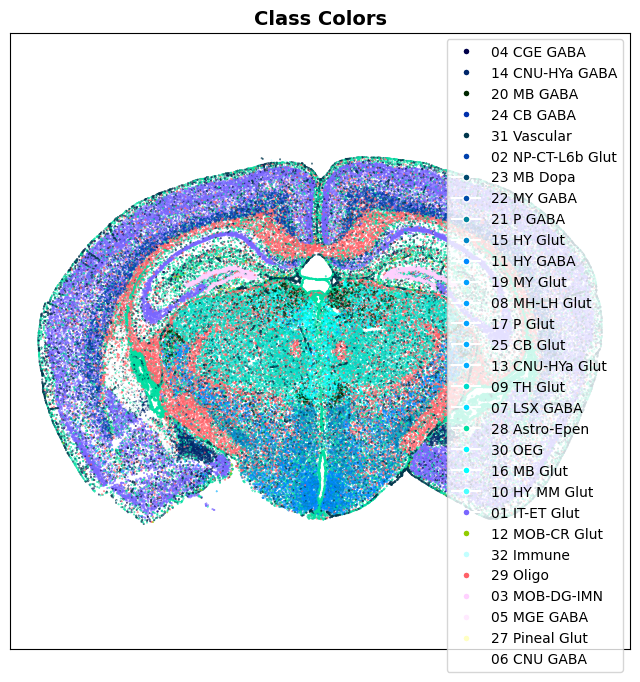

In [ ]:
plot_section_class(new_section)